In [255]:
import csv # import csv library  
import shapely
import shapefile

In [256]:
import geopandas as gpd
import pandas as pd

In [257]:
from matplotlib import pyplot as plt
from descartes import PolygonPatch
from shapely.geometry import Polygon, mapping
from shapely.geometry.multipolygon import MultiPolygon
from shapely import wkt
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline

In [258]:
#import matplotlib.pyplot as plt
# The two statemens below are used mainly to set up a plotting
# default style that's better than the default from Matplotlib 1.x
# Matplotlib 2.0 supposedly has better default styles.
#import seaborn as sns
#plt.style.use('bmh')
from shapely.geometry import Point
from geopandas import GeoSeries, GeoDataFrame

# GetData

In [259]:
df = pd.read_csv('OriginalDataBaseFile/RealPropertiesExtraClean.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223231 entries, 0 to 223230
Data columns (total 7 columns):
Parcel         223231 non-null object
FullAddress    223231 non-null object
IsVacant       223231 non-null int64
ID             223231 non-null int64
IsMCC          223231 non-null int64
BlockLot       223231 non-null object
CxHull         223231 non-null int64
dtypes: int64(4), object(3)
memory usage: 11.9+ MB


In [260]:
# rename
df.rename(columns={"Parcel":"geometry"},inplace=True)
# string to multipolygon
df.geometry = df.geometry.apply(lambda var: MultiPolygon([wkt.loads(var)]))
# geodataframe
gdf = gpd.GeoDataFrame(df)
gdf["Block"] = gdf.BlockLot.apply(lambda num: num[:4])
gdf.head(1)

,geometry,FullAddress,IsVacant,ID,IsMCC,BlockLot,CxHull,Block
0,(POLYGON ((-76.65105993257878 39.3093099706816...,2041 W NORTH AVE,1,1,0,0001 003,0,0001


In [7]:
gdf.geometry.bounds.describe()

,minx,miny,maxx,maxy
count,223231.000000,223231.000000,223231.000000,223231.000000
mean,-76.618185,39.311654,-76.617878,39.311892
std,0.044991,0.031067,0.044987,0.031103
min,-76.711313,39.197287,-76.711267,39.200573
25%,-76.653881,39.288808,-76.653535,39.288948
50%,-76.612600,39.309093,-76.612314,39.309269
75%,-76.583404,39.336265,-76.583171,39.336561
max,-76.529713,39.372002,-76.529671,39.372022


In [8]:
gdf.geometry.area.describe()

count    2.232310e+05
mean     7.661022e-08
std      1.096795e-06
min      1.372733e-11
25%      1.074227e-08
50%      1.677546e-08
75%      3.636451e-08
max      2.956321e-04
dtype: float64

In [261]:
# get house set
gdf[gdf.geometry.area> 5e-08].shape
gdf[gdf.geometry.area< 3e-09].shape
gdf = gdf[(gdf.geometry.area> 3e-09) & (gdf.geometry.area< 5e-08) ] # (gdf.ID.apply(lambda var: var in idsettotal))]
gdf.shape

(176474, 8)

In [133]:
# get house set
print gdf.IsVacant.value_counts()
ogdf = gdf[gdf.IsVacant == 0]
vgdf = gdf[gdf.IsVacant == 1]

0    160748
1     15726
Name: IsVacant, dtype: int64


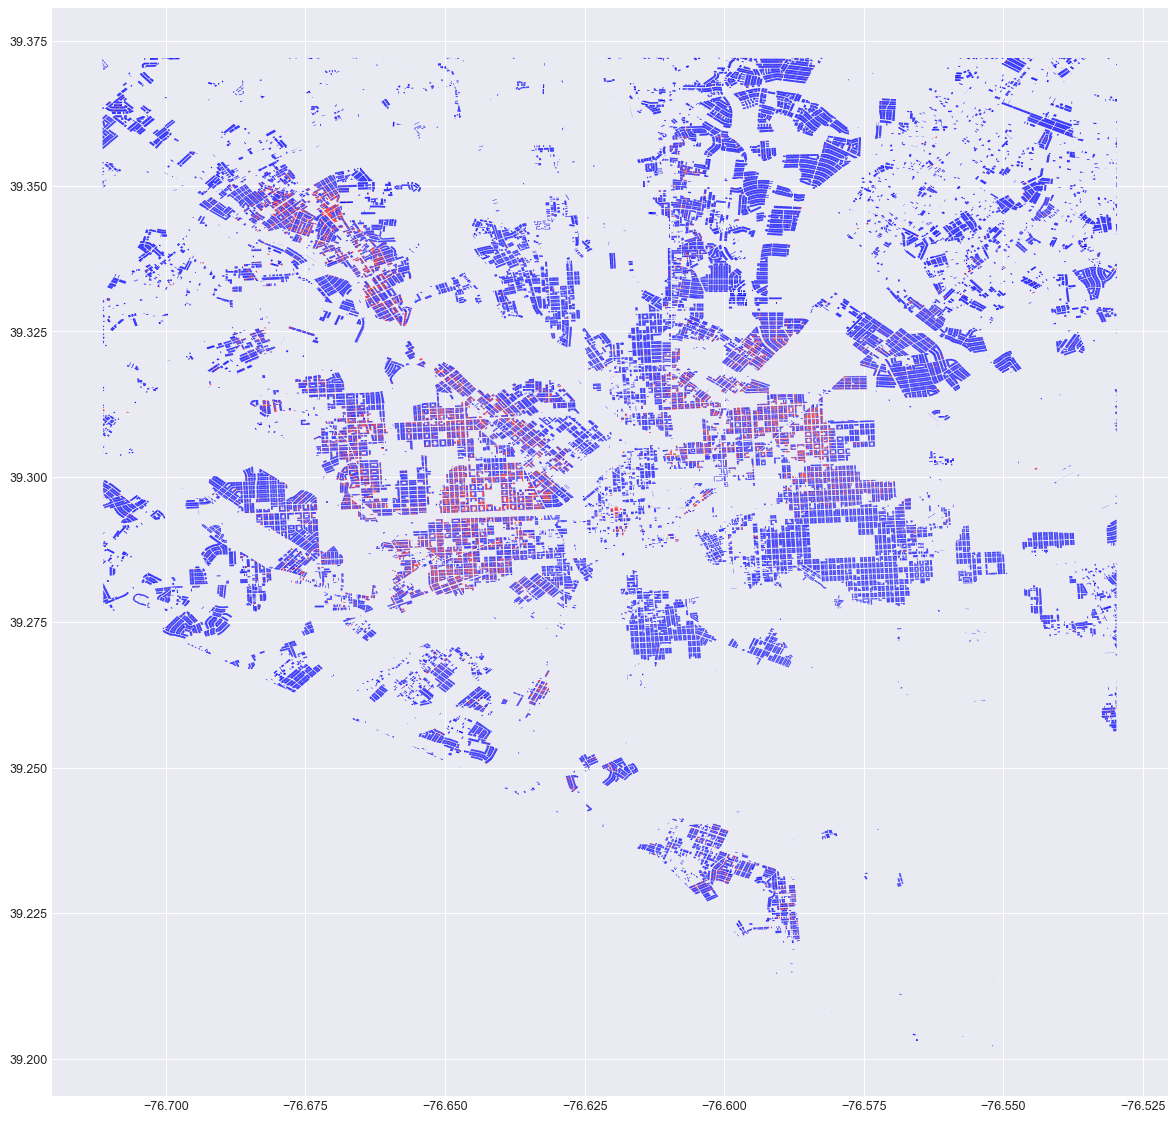

In [36]:
fig = plt.figure(1, figsize=(16,16), dpi=90)
ax = fig.add_subplot(111)
ogdf.plot(ax = ax,color = 'b')
vgdf.plot(ax=ax,color = 'r')

## Revisit Distance

In [262]:
gdf.crs = {'init' :'epsg:4326'}

In [263]:
from math import radians
gdf['x'] = gdf.geometry.centroid.x
gdf['xradians'] = gdf.x.apply(radians)
gdf['y'] = gdf.geometry.centroid.y
gdf['yradians'] = gdf.y.apply(radians)
gdf['yx'] = zip(gdf.y,gdf.x)

In [264]:
import time

In [137]:
s = time.time()
import geopy.distance as gpydistance
gdf.yx[:].apply(lambda var: gpydistance.vincenty(var,gdf.yx[:1])*1000)
print time.time()-s

25.4720070362


In [138]:
s = time.time()
from geopy.distance import great_circle
gdf.yx[:].apply(lambda var: great_circle(var,gdf.yx.iloc[0]).meters)
print time.time()-s

7.67311406136


In [139]:
# math package
# approximate radius of earth in meters
from math import sin, cos, sqrt, atan2
def real_dis(col,lon2,lat2):
    lon1, lat1 = col
    R = 6373.0
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c*1000
s = time.time()
gdf[['xradians','yradians']][:].apply(real_dis, args=(gdf.xradians.iloc[0], gdf.yradians.iloc[0],),axis = 1)
print time.time()-s

4.29115200043


In [265]:
# skip last rows
# ( (137238 rows affected)	NaN	NaN	NaN )
df2 = pd.read_csv('OriginalDataBaseFile/RealGoodNeighbors.csv',low_memory=False,skiprows = lambda x: x == 137240 )
df2.info()
df2.head(1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137238 entries, 0 to 137237
Data columns (total 4 columns):
aID          137238 non-null int64
aBlockLot    137238 non-null object
bID          137238 non-null int64
bBlockLot    137238 non-null object
dtypes: int64(2), object(2)
memory usage: 4.2+ MB


,aID,aBlockLot,bID,bBlockLot
0,2,0001 005,59,0001 006


In [266]:
# check data only appair in edge set
idseta = set(df2.aID.unique())
idsetb = set(df2.bID.unique())
idsettotal = idseta.union(idsetb)
#gdf = gdf[gdf.ID.apply(lambda var: var in idsettotal)]
print len(df2)

137238


In [267]:
# final edge set
gdf['xyradians'] = zip(gdf.xradians,gdf.yradians)
gdf['xyrID'] = zip(gdf.xyradians,gdf.ID)
df2 = df2[(df2.aID.isin(set(gdf.ID))) & (df2.bID.isin(set(gdf.ID)))]
ogdf = gdf[gdf.IsVacant == 0]
vgdf = gdf[gdf.IsVacant == 1]
# houseset
print "total:", len(gdf)
print "residents:" ,len(ogdf)
print "vacant:", len(vgdf)
print "edges:", len(df2)

total: 176474
residents: 160748
vacant: 15726
edges: 132489


Text(0.5,1,u'adjacent plot')

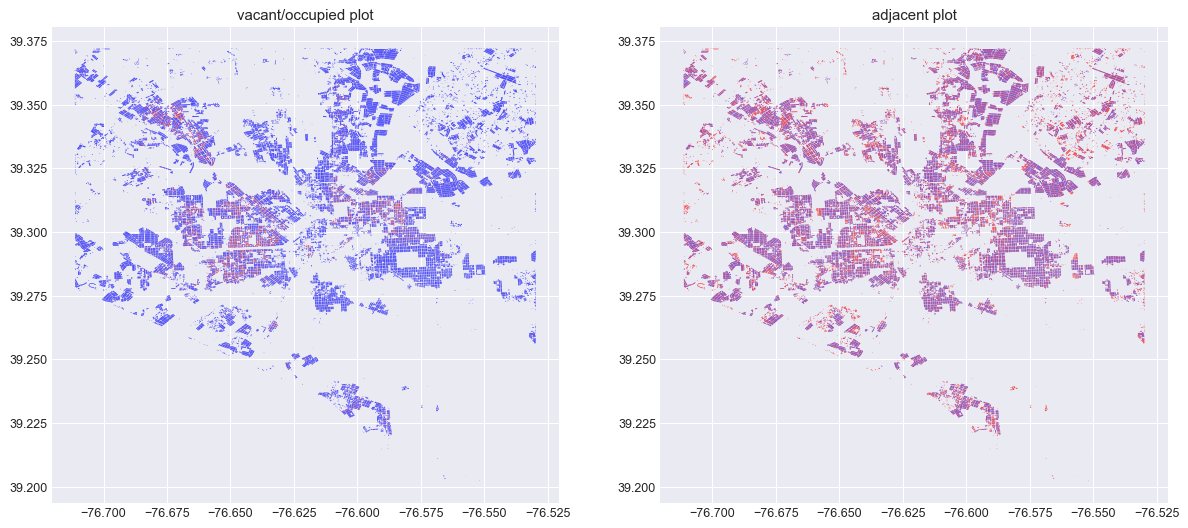

In [150]:
fig = plt.figure(1, figsize=(16,7), dpi=90)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ogdf.plot(ax = ax1,color = 'b')
vgdf.plot(ax=ax1,color = 'r')
ax1.set_title("vacant/occupied plot")

gdf1 = gdf[gdf.ID.apply(lambda var: var in idseta)]
gdf2 = gdf[gdf.ID.apply(lambda var: var not in idseta)]
gdf1.plot(ax = ax2,color = 'b')
gdf2.plot(ax=ax2,color = 'r')
ax2.set_title("adjacent plot")

In [268]:
from gurobipy import *
import numpy as np

### Get Edge Set

In [269]:
#(df2.aID.apply(lambda var: var in set(gdf.ID))) and (df2.bID.apply(lambda var: var in set(gdf.ID))) 
amerge = pd.merge(df2,gdf,left_on=["aID"],right_on=["ID"])

In [270]:
bmerge = pd.merge(df2,gdf,left_on=["bID"],right_on=["ID"])

In [271]:
edge = pd.merge(amerge,bmerge,left_on=["aID","bID"],right_on=["aID","bID"]).iloc[:,:4]

In [389]:
#gdf,ogdf,vgdf,edge
edge.rename(columns={"aBlockLot_x":"aBlockLot","bBlockLot_x":"bBlockLot"},inplace=True)

In [419]:
Budget = 5000000
demolish_2_story, demolish_3_story = 13000, 22000
r_relocate, o_relocate = 85000, 170000
wall_2_story, wall_3_story = 14000, 25000
cost_reduction = 2000

In [420]:
# cost
Cost = [ 13000 +
      (85000 if gdf.loc[i,"IsVacant"]== 0 else 0) 
        for i in gdf.index ]

# Rdduction
Benefit = [ cost_reduction
             for i in xrange(len(edge))]

# 01-10-18
wi = [ 14000 
     for i in xrange(len(edge))]

wj = [ 14000 
         for i in xrange(len(edge))]

In [275]:
print("Cost:" , Cost[:5])
print("Wall for i:" , wi[:5])
print("Wall for j:" , wj[:5])
print("cost reduction:" , Benefit[:5])

('Cost:', [13000, 98000, 98000, 13000, 98000])
('Wall for i:', [14000, 14000, 14000, 14000, 14000])
('Wall for j:', [14000, 14000, 14000, 14000, 14000])
('cost reduction:', [2000, 2000, 2000, 2000, 2000])


In [276]:
test0 = Model() # empty
test0.Params.Threads = 4
x = test0.addVars(gdf.ID,vtype = GRB.BINARY,name = "x")
#z = test0.addVars(Edge,vtype = GRB.BINARY,name = "z")

edgetuple = zip(edge.aID,edge.bID)
y = test0.addVars(edgetuple,vtype = GRB.BINARY,name = "y")
bigM = test0.addVars(vgdf.ID,vtype = GRB.CONTINUOUS,name = "bigM",lb = -GRB.INFINITY, ub = 0.0)

Changed value of parameter Threads to 4
   Prev: 0  Min: 0  Max: 1024  Default: 0


In [412]:
test0.update()
Budget_Constraint = test0.addConstr((quicksum(Cost[i]*x[gdf.ID.iloc[i]] for i in xrange(len(gdf))) -
                     quicksum((Benefit[i]+wi[i]+wj[i])*y[edgetuple[i]] for i in xrange(len(edgetuple))) +
                     quicksum(wi[i]*x[edgetuple[i][1]] for i in xrange(len(edgetuple))) +
                     quicksum(wj[i]*x[edgetuple[i][0]] for i in xrange(len(edgetuple))) 
                     <= 
                     Budget 
                    )
                     , name = "Budget_Constraint")


In [277]:
CD1 = test0.addConstrs((x[edgetuple[i][1]] + x[edgetuple[i][0]] - y[edgetuple[i]] <= 1 
                      for i in xrange(len(edgetuple))
                     ),name = "CD1")

CD2 = test0.addConstrs((-x[edgetuple[i][1]]  + y[edgetuple[i]] <= 0 
                      for i in xrange(len(edgetuple))
                     ),name = "CD2")

CD3 = test0.addConstrs((-x[edgetuple[i][0]]  + y[edgetuple[i]] <= 0 
                      for i in xrange(len(edgetuple))
                     ),name = "CD3")

In [278]:
def real_dis_affect(col,col2):
    lon1, lat1 = col
    lon2, lat2 = col2
    R = 6373.0
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    dis = R * c*1000 
    return 1/dis if dis < 240 else 0
#gdf[['xradians','yradians']][:].apply(real_dis, args=(gdf.xradians.iloc[0], gdf.yradians.iloc[0],),axis = 1)

In [237]:
# method 1
import sys
s = time.time()
for h in xrange(5):
    test0.addConstr(( bigM[vgdf.ID.iloc[h]] 
                     <= quicksum(
                        real_dis_affect(vgdf.xyradians.iloc[h],ogdf.xyradians.iloc[v])*(x[ogdf.ID.iloc[v]]-1) for v in xrange(len(ogdf)) 
                     ) + 200000.0*x[vgdf.ID.iloc[h]] ) , name = "occupied"+str(h) ) 
    #test0.addConstr(( bigM[h] <= 100000000000*(1-x[h]) ))
                     #+ quicksum(affect(h,v) for v in Vacants)*x[h]), name = str(h))
    
    if (h+1)%10 == 0:
        sys.stdout.write(str(h+1)+"/91216 files , time: "+str(time.time()-s)+'\r')
        sys.stdout.flush()

In [238]:
print "time:", time.time()-s

time: 58.436152935


In [245]:
s = time.time()
vgdf.xyradians[:].apply(real_dis_affect, args=(ogdf.xyradians.iloc[0],))
time.time() - s

0.049603939056396484

In [246]:
s = time.time()
ogdf.xyradians[:].apply(real_dis_affect, args=(vgdf.xyradians.iloc[0],))
time.time() - s

0.3197319507598877

In [239]:
# method 2
import sys
s = time.time()
for h in xrange(5):
    affectdf = ogdf.xyradians.apply(real_dis_affect, args=(vgdf.xyradians.iloc[h],))
    test0.addConstr(( bigM[vgdf.ID.iloc[h]] 
                     <= quicksum(
                        affectdf.iloc[v]*(x[ogdf.ID.iloc[v]]-1) for v in xrange(len(ogdf)) 
                     ) + sum(affectdf)*x[vgdf.ID.iloc[h]] ) , name = "occupied"+str(h) ) 
    #test0.addConstr(( bigM[h] <= 100000000000*(1-x[h]) ))
                     #+ quicksum(affect(h,v) for v in Vacants)*x[h]), name = str(h))
    
    if (h+1)%50 == 0:
        sys.stdout.write(str(h+1)+"/91216 files , time: "+str(time.time()-s)+'\r')
        sys.stdout.flush()

In [240]:
print "time:", time.time()-s

time: 46.6510000229


In [253]:
s = time.time()
quicksum(vgdf.xyrID.apply(lambda var: real_dis_affect(var[0],ogdf.xyradians.iloc[0])*(x[var[1]]-1)))
time.time() - s

0.5761759281158447

In [254]:
s = time.time()
quicksum(ogdf.xyrID.apply(lambda var: real_dis_affect(var[0],vgdf.xyradians.iloc[0])*(x[var[1]]-1)))
time.time() - s

5.615530014038086

In [280]:
# method 3
import sys
s = time.time()
for h in xrange(len(vgdf)):
    test0.addConstr(( bigM[vgdf.ID.iloc[h]] 
                     <= quicksum(
                         ogdf.xyrID.apply(lambda var: real_dis_affect(var[0],vgdf.xyradians.iloc[h])*(x[var[1]]-1))
                            )
                     + 200000.0*x[vgdf.ID.iloc[h]] ) , name = "occupied"+str(h) ) 
    #test0.addConstr(( bigM[h] <= 100000000000*(1-x[h]) ))
                     #+ quicksum(affect(h,v) for v in Vacants)*x[h]), name = str(h))
    
    if (h+1)%10 == 0:
        sys.stdout.write(str(h+1)+"/" +str(len(vgdf))+ " files , time: "+str(time.time()-s)+'\r')
        sys.stdout.flush()

In [281]:
time.time()-s

98073.74595499039

In [413]:
test0.setObjective( quicksum(bigM[i] for i in vgdf.ID), GRB.MAXIMIZE)
test0.optimize()

Optimize a model with 413201 rows, 324689 columns and 8516862 nonzeros
Variable types: 15726 continuous, 308963 integer (308963 binary)
Coefficient statistics:
  Matrix range     [4e-03, 2e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-02, 5e+06]
Found heuristic solution: objective -63342.5
Presolve removed 3 rows and 9198 columns (presolve time = 5s) ...
Presolve removed 3 rows and 9198 columns (presolve time = 10s) ...
Presolve removed 14835 rows and 18759 columns (presolve time = 15s) ...
Presolve removed 21969 rows and 22924 columns (presolve time = 20s) ...
Presolve removed 28613 rows and 26795 columns (presolve time = 25s) ...
Presolve removed 30570 rows and 27748 columns (presolve time = 30s) ...
Presolve removed 31374 rows and 28523 columns (presolve time = 36s) ...
Presolve removed 31932 rows and 28725 columns (presolve time = 40s) ...
Presolve removed 31932 rows and 28725 columns
Presolve time: 42.22s
Presolved: 381269 rows, 29

In [414]:
xcoord = vgdf[ (vgdf.ID.apply(lambda var: abs(x[var].X -1) < 0.00001 ))  ].geometry.centroid.x
ycoord = vgdf[ (vgdf.ID.apply(lambda var: abs(x[var].X -1) < 0.00001 ))  ].geometry.centroid.y

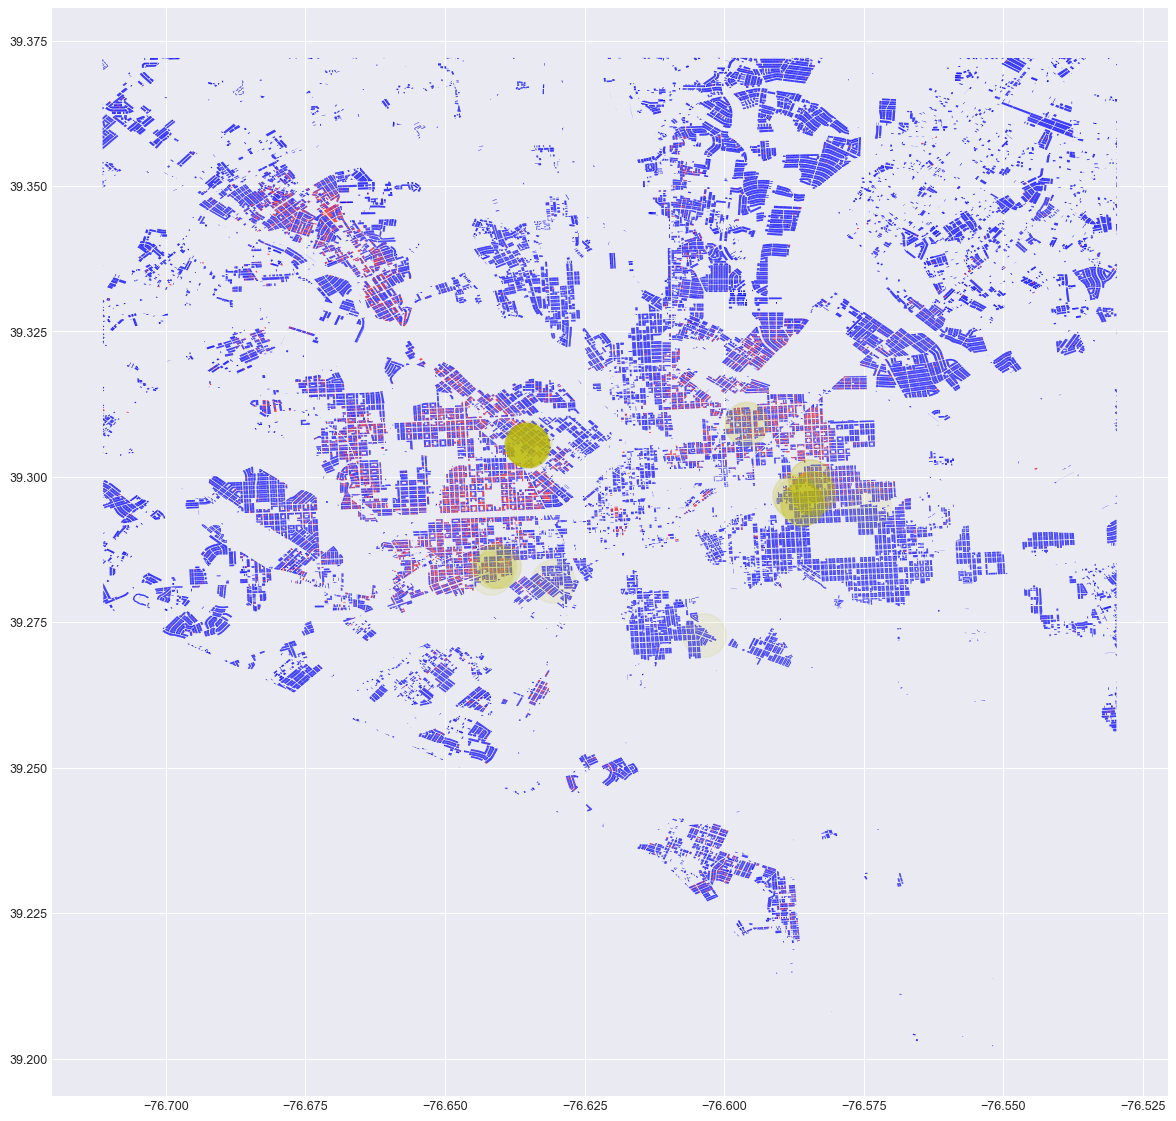

In [415]:
fig = plt.figure(1, figsize=(16,16), dpi=90)
ax = fig.add_subplot(111)
ogdf.plot(ax = ax,color = 'b')
vgdf[vgdf.ID.apply(lambda var: abs(x[var].x -1) < 0.00001 ) ].plot(ax = ax, color = 'g')
vgdf[vgdf.ID.apply(lambda var: abs(x[var].x -1) > 0.00001 ) ].plot(ax = ax, color = 'r')

fig.savefig('newimages/power1-distance240-nonnormal-05.eps',format='eps', dpi=1000,bbox_inches='tight')
plt.scatter(x=xcoord, y=ycoord, alpha=0.1, c='y',s = 1200)
fig.savefig('newimages/power1-distance240-nonnormal-05.svg', format='svg', dpi=1200,bbox_inches='tight')

In [ ]:
#status = []

## get status

In [418]:
spent = (sum(Cost[i]*x[gdf.ID.iloc[i]].X for i in xrange(len(gdf))) -
         sum((Benefit[i]+wi[i]+wj[i])*y[edgetuple[i]].X for i in xrange(len(edgetuple))) +
         sum(wi[i]*x[edgetuple[i][1]].X for i in xrange(len(edgetuple))) +
         sum(wj[i]*x[edgetuple[i][0]].X for i in xrange(len(edgetuple))) )
         
        
num_houses = sum(x[i].X  for i in gdf.ID)
    
#print "Budget : %s   number of houses : %s" %(spent, num_houses)
print("Budget : %s   number of houses : %s   ObjVal : %s   Running Time : %s" %
       (spent,num_houses,test0.ObjVal,test0.Runtime))
status.append("Budget : %s   number of houses : %s   ObjVal : %s   Running Time : %s" %
       (spent,num_houses,test0.ObjVal,test0.Runtime))

Budget : 488000.0   number of houses : 40.0   ObjVal : -63089.466106   Running Time : 92.4861860275


In [417]:
status

['Budget : 488000.0   number of houses : 40.0   ObjVal : -63089.1863122   Running Time : 93.0150620937',
 'Budget : 488000.0   number of houses : 40.0   ObjVal : -63089.2216757   Running Time : 102.424516916',
 'Budget : 488000.0   number of houses : 40.0   ObjVal : -63089.2571082   Running Time : 119.486876011',
 'Budget : 488000.0   number of houses : 40.0   ObjVal : -63089.3055079   Running Time : 98.7545449734',
 'Budget : 500000.0   number of houses : 40.0   ObjVal : -63087.7750233   Running Time : 115.366982937',
 'Budget : 488000.0   number of houses : 40.0   ObjVal : -63089.466106   Running Time : 92.4861860275']

## leave solution out

In [411]:
if sum(x[gdf.ID.iloc[i]].X for i in xrange(len(gdf))) != 0:

    test0.addConstr(
        (
        quicksum(x[gdf.ID.iloc[i]] 
                 if x[gdf.ID.iloc[i]].X == 1 or abs(x[gdf.ID.iloc[i]].X - 1.0) < 0.000001 
                 else 0 for i in xrange(len(gdf)))
        <= sum( 1
               if x[gdf.ID.iloc[i]].X == 1 or abs(x[gdf.ID.iloc[i]].X - 1.0) < 0.000001 
               else 0 for i in xrange(len(gdf)))-1
        ),name = 'temp'
    )

## write model

In [98]:
# write model
test0.write('model-01-28-18.lp')
test0.write('model-01-28-18.mps') 
test0.write('model-01-28-18.prm') 

In [375]:
output[output.demolish == 1].Block.value_counts()

0327    15
1654     4
1688     4
1623     3
1655     2
1652     2
1118     2
0264     2
2011     1
0847     1
1669     1
0850     1
0328     1
0263     1
Name: Block, dtype: int64

## shape file

In [347]:
output = gdf.sort_values(by = "ID")

In [349]:
output["demolish"] = output.ID.apply(lambda var: x[var].x)

In [357]:
output.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 176474 entries, 0 to 223230
Data columns (total 16 columns):
geometry       176474 non-null object
FullAddress    176474 non-null object
IsVacant       176474 non-null int64
ID             176474 non-null int64
IsMCC          176474 non-null int64
BlockLot       176474 non-null object
CxHull         176474 non-null int64
Block          176474 non-null object
x              176474 non-null float64
xradians       176474 non-null float64
y              176474 non-null float64
yradians       176474 non-null float64
yx             176474 non-null object
xyradians      176474 non-null object
xyrID          176474 non-null object
demolish       176474 non-null float64
dtypes: float64(5), int64(4), object(7)
memory usage: 22.9+ MB


In [368]:
output.demolish = output.demolish.apply(lambda var : int(var))

In [370]:
output.demolish.value_counts()

0    176434
1        40
Name: demolish, dtype: int64

In [371]:
output.head()

,geometry,FullAddress,IsVacant,ID,IsMCC,BlockLot,CxHull,Block,x,xradians,y,yradians,yx,xyradians,xyrID,demolish
0,(POLYGON ((-76.65105993257878 39.3093099706816...,2041 W NORTH AVE,1,1,0,0001 003,0,0001,-76.651043,-1.337813,39.309426,0.686079,"(39.309425534, -76.6510427751)","(-1.33781307151, 0.686078902635)","((-1.33781307151, 0.686078902635), 1)",0
1,(POLYGON ((-76.65095905272662 39.3093132946162...,2037 W NORTH AVE,0,2,0,0001 005,0,0001,-76.650944,-1.337811,39.309429,0.686079,"(39.3094289897, -76.650943861)","(-1.33781134514, 0.686078962949)","((-1.33781134514, 0.686078962949), 2)",0
2,(POLYGON ((-76.65066160640897 39.3093231460410...,2025 W NORTH AVE,0,3,0,0001 011,0,0001,-76.650648,-1.337806,39.309439,0.686079,"(39.3094387773, -76.6506480079)","(-1.33780618152, 0.686079133775)","((-1.33780618152, 0.686079133775), 3)",0
3,(POLYGON ((-76.65024544152686 39.3089271320864...,1806 N PAYSON ST,1,4,0,0001 028,0,0001,-76.650105,-1.337797,39.308951,0.686071,"(39.3089514659, -76.6501053222)","(-1.33779670987, 0.686070628586)","((-1.33779670987, 0.686070628586), 4)",0
4,"(POLYGON ((-76.65024121812105 39.308851948091,...",1802 N PAYSON ST,0,5,0,0001 030,0,0001,-76.650101,-1.337797,39.308876,0.686069,"(39.3088760684, -76.6501010663)","(-1.33779663559, 0.686069312651)","((-1.33779663559, 0.686069312651), 5)",0


In [372]:
# no tuple in entry
output.drop(["yx","xyradians","xyrID"],axis = 1).to_file('output020118.shp')

# Parallel constraint generation is not possible in Gurobi ( or slower )

https://groups.google.com/forum/#!msg/gurobi/0t8_5wtjYSI/67awe7QcBAAJ

In [170]:
from geopy.distance import great_circle
#newport_ri = (41.49008, -71.312796)
#cleveland_oh = (41.499498, -81.695391)
#great_circle(newport_ri, cleveland_oh).meters

def affect(x1,x2):
    dis = great_circle((x1.x,x1.y),
              (x2.x,x2.y)).meters
    return 1.0/dis if dis <= 240 else 0
#print affect(Map[1][1],Map[1][2])

In [42]:
thread = 5

from multiprocessing import Process
from joblib import Parallel, delayed
import time
s = time.time()

#def producer():
#    for i in range(10):
#        yield i

def f(h):
    #l.acquire()
    
    test0.addConstrs(( bigM[ogdf.ID.iloc[i]] 
                     <= quicksum(
                        affect(ogdf.geometry.iloc[i].centroid,
                               vgdf.geometry.iloc[v].centroid)
                              *(x[vgdf.ID.iloc[v]]-1) for v in xrange(len(vgdf))) + 200000.0*x[ogdf.ID.iloc[i]] 
                      for i in xrange(h-thread,h)) 
                    , name = "for each occupied") 
    """
    if (h+1)%10 == 0:
        sys.stdout.write(str(1.0*(h+1)/153788*100)+" , "+str(time.time()-s)+'\r')
        sys.stdout.flush()
    """
    #print "g"
    #l.release()

Parallel(n_jobs=4,backend="threading")(delayed(f)(i) for i in  xrange(thread,81,thread))

        
print("time:", (time.time()-s)/80  )

('time:', 5.106696212291718)


In [81]:
#test0.Params.Threads = 0
from multiprocessing import Process
from joblib import Parallel, delayed
import time
s = time.time()

#def producer():
#    for i in range(10):
#        yield i

def f(i):
    #l.acquire()
   
    
    test0.addConstr(( bigM[ogdf.ID.iloc[i]] 
                     <= quicksum(
                        affect(ogdf.geometry.iloc[i].centroid,
                               vgdf.geometry.iloc[v].centroid)
                              *(x[vgdf.ID.iloc[v]]-1) for v in xrange(len(vgdf))) + 200000.0*x[ogdf.ID.iloc[i]] 
                     ) 
                    , name = "for each occupied") 
    test0.update()
    if (i+1)%10 == 0:
        sys.stdout.write(str(1.0*(i+1)/153788*100)+" percent , "+str(time.time()-s)+'\r')
        sys.stdout.flush()
    
    rtn = 99
    #print "g"
    #l.release()

Parallel(n_jobs=4)(delayed(f)(i) for i in  xrange(0,80))

        
print("time:", (time.time()-s)/80 )

('time:', 1.2877171248197556).921424158


In [38]:
from multiprocessing import Pool, TimeoutError
import time
import os
import sys



def f(h):
    #total = sum( [affect(ogdf.geometry.iloc[h].centroid,vgdf.geometry.iloc[v].centroid) 
    #              for v in xrange(len(vgdf))])
    
    global count
    global s
    if count > 50:
        return
    
    
    test0.addConstr(( bigM[ogdf.ID.iloc[h]] 
                     <= quicksum(
                        affect(ogdf.geometry.iloc[h].centroid,
                               vgdf.geometry.iloc[v].centroid)
                              *(x[vgdf.ID.iloc[v]]-1) for v in xrange(len(vgdf))) + 200000.0*x[ogdf.ID.iloc[h]] ) , name = "for each occupied") 
    

    count += 1
    
    if (count)%10 == 0:
        sys.stdout.write(str(1.0*(count)/153788*100)+" , "+str(time.time()-s)+'\r')
        sys.stdout.flush()

    
    
if __name__ == '__main__':
    

    pool = Pool(processes=3)
    
    count = 0
    s = 0
    pool.map(f, range(3))
    # allows the system to recognize four total "cores" or "threads" (two real and two virtual).
    
    s = time.time() 
    count = 0
    
    pool.map(f, range(len(ogdf)))
    
    pool.close()
    #test0.setObjective( quicksum(bigM[i] for i in Occupied), GRB.MAXIMIZE)

print("time:", time.time()-s)

('time:', 248.27418208122253)64


In [323]:
len(ogdf)

160748